# Core: Applying 3-Category Classifier for Mapping
Utilize already-trained model to create comprehensive LULC classifications from imagery, either downloaded or on-the-fly. Using chips and scoring models is not included.  

This is intended as a milestone notebook for preserving a confirmed workflow.
  
Date: 2019-06-26  
Author: DC Team  

### Import statements

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import shapely
import cartopy
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

import tensorflow as tf

import descarteslabs as dl
print (dl.places.find('illinois')) ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
sys.path.append(ULU_REPO)
print (sys.path)

import util_vectors
import util_workflow
import util_mapping

[
  {
    'bbox': [-91.512974, 36.970298, -87.019935, 42.508302],
    'id': 85688697,
    'name': 'Illinois',
    'path': 'continent:north-america_country:united-states_region:illinois',
    'placetype': 'region',
    'slug': 'north-america_united-states_illinois'
  }
]
['/home/Peter.Kerins/anaconda3/envs/geoml/lib/python36.zip', '/home/Peter.Kerins/anaconda3/envs/geoml/lib/python3.6', '/home/Peter.Kerins/anaconda3/envs/geoml/lib/python3.6/lib-dynload', '', '/home/Peter.Kerins/anaconda3/envs/geoml/lib/python3.6/site-packages', '/home/Peter.Kerins/anaconda3/envs/geoml/lib/python3.6/site-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils', '/home/Peter.Kerins/UrbanLandUse']


## Preparation

### Set key variables

In [2]:
# core
data_root='/data/phase_iv/'
place = 'kanpur'
data_path=data_root+place+'/'

resolution = 5  # Lx:15 S2:10

# tiling
tile_resolution = resolution
tile_size = 256
tile_pad = 32


# misc
s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx

# ground truth source: aue, aue+osm, aue+osm2
# label_suffix = 'aue'

### Load and inspect study area

simple polygon
center co-ordinates 80.42123499984538 26.420215000022125


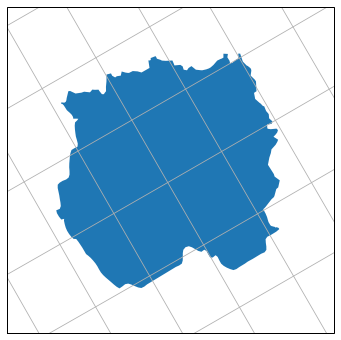

In [3]:
# print place, place.title() # capitalized version of place name
place_title = place.title()
place_shapefile = data_path+place_title+"_studyAreaEPSG4326.shp"

# util_vectors.info_studyareas(data_path, place)

shape = util_vectors.load_shape(place_shapefile)
polygon = shape['geometry']['coordinates']
# print(polygon)
# pprint(shape)
place_bbox = shape['bbox']
# print(bbox)

# using Albers projection
lonlat_crs = cartopy.crs.PlateCarree()
clat, clon = (place_bbox[0]+place_bbox[2])/2.0, (place_bbox[1]+place_bbox[3])/2.0
print ("center co-ordinates", clat, clon)
albers = cartopy.crs.AlbersEqualArea(central_latitude=clat, central_longitude=clon)

# visualize Study Region
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(projection=albers) # Specify projection of the map here
shp = shapely.geometry.shape(shape['geometry'])
ax.add_geometries([shp], lonlat_crs)
ax.set_extent((place_bbox[0], place_bbox[2], place_bbox[1], place_bbox[3]), crs=lonlat_crs)
ax.gridlines(crs=lonlat_crs)
plt.show()

### Generate tiles

number of tiles to cover region 1432
dict_keys(['geometry', 'type', 'properties'])
tile022 {
  'coordinates': [[[80.13816896797299, 26.451012173638084], [80.15421654759992, 26.451108064614825], [80.15411098095933, 26.46555333963205], [80.13806139894912, 26.465457388285653], [80.13816896797299, 26.451012173638084]]],
  'type': 'Polygon'
}


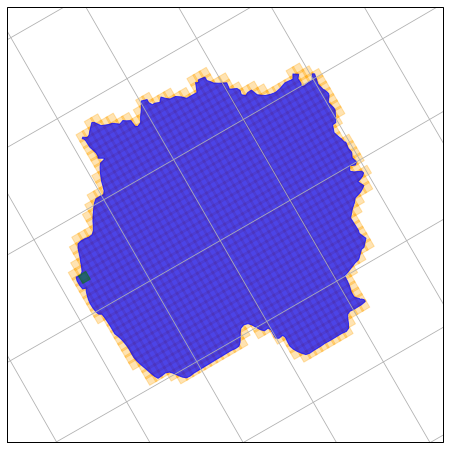

In [4]:
tiles = dl.raster.dltiles_from_shape(tile_resolution, tile_size, tile_pad, shape)
single_tile_id = 22
highlights = {single_tile_id:'green'}
util_vectors.draw_tiled_area(shape, tiles, albers, lonlat_crs, highlights=highlights)

### Set input stack and model parameters

In [5]:
window = 17

# bands stuff outdated! needs to be reconciled with catalog filtering
# will ignore for the moment since this is a bigger fix...
# haven't done any examples yet incorporating additional chips beyond s2
# into construction of a training sample
bands_vir=s2_bands[:-1]
bands_sar=None
bands_ndvi=None
bands_ndbi=None
bands_osm=None

# this can get updated when cloudmasking is added
haze_removal = False

batch_size = 128
balancing = None

# move as appropriate

model_id = '3cat_14ct_green_2017_2-img-bl'
unflatten_input = True # is the model a cnn?
n_cats = 3 # number of categories

water_overwrite = False
water_mask = False

In [6]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print (stack_label, feature_count)

vir 6


### Load model
Includes loading custom loss function used during training

In [7]:
# category_weights_filename = data_root+'models/'+model_id+'_category_weights.pkl'
# category_weights = pickle.load( open( category_weights_filename, "rb" ) )
# weights = list(zip(*category_weights.items())[1])

network_filename = data_root+'models/'+model_id+'.hd5'
network = tf.keras.models.load_model(
    network_filename,
    custom_objects={'loss': 'categorical_crossentropy'},
    compile=True
)
# network = K.load_model(network_filename, custom_objects={'loss': 'categorical-crossentropy'})
network.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 17, 17, 6)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 17, 17, 32)   1760        input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 17, 17, 32)   0           conv2d_4[0][0]                   
________________________________________________________________________

***

## Apply model: mapping
Apply model to imagery to classify all pixels in all non-empty tiles in all scenes.

In [11]:
zfill=5
store_predictions=True
map_id=place+'_test'

In [12]:
scene_ids = ['sentinel-2:L1C:2017-12-08_44RMQ_42_S2B_v1', 'sentinel-2:L1C:2017-12-10_44RMP_27_S2A_v1', 'sentinel-2:L1C:2017-12-10_44RMQ_54_S2A_v1', 'sentinel-2:L1C:2017-12-13_44RMQ_42_S2A_v1', 'sentinel-2:L1C:2017-12-15_44RMP_99_S2B_v1', 'sentinel-2:L1C:2017-12-15_44RMQ_98_S2B_v1', 'sentinel-2:L1C:2017-12-25_44RMP_99_S2B_v1', 'sentinel-2:L1C:2018-01-14_44RMP_99_S2B_v1', 'sentinel-2:L1C:2018-01-14_44RMQ_98_S2B_v1', 'sentinel-2:L1C:2018-01-19_44RMP_29_S2A_v1', 'sentinel-2:L1C:2018-01-19_44RMQ_52_S2A_v1', 'sentinel-2:L1C:2018-01-22_44RMQ_34_S2A_v1', 'sentinel-2:L1C:2018-01-24_44RMP_99_S2B_v1', 'sentinel-2:L1C:2018-01-24_44RMQ_98_S2B_v1', 'sentinel-2:L1C:2018-01-29_44RMP_99_S2A_v1', 'sentinel-2:L1C:2018-01-29_44RMQ_98_S2A_v1']

In [ ]:
util_mapping.map_scenes_simple(scene_ids, tiles, network, zfill=zfill, store_predictions=store_predictions, map_id=map_id)

----------------------------------------------

***